<Figure size 432x288 with 0 Axes>

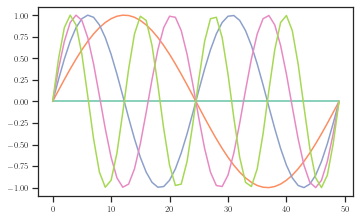

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import path

PT_PER_INCH = 72.27
GOLDEN_RATIO = (5**.5 - 1) / 2

TEXTWIDTH_PT = 408.0 # \showthe\textwidth
TEXTWIDTH_IN = TEXTWIDTH_PT/PT_PER_INCH

REPORT_PATH = "report"
FIGURES_PATH = path.join("report", "figures")
STYLE_PATH = path.join("report", "thesis.mplstyle")

RC_PARAMS = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "figure.titlesize": 12,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

def figsize(fraction=1.0, width=TEXTWIDTH_IN, ratio=GOLDEN_RATIO, subplots=(1, 1)):
    fig_width = fraction*width
    fig_height = fig_width*ratio*(subplots[0]/subplots[1])
    return fig_width, fig_height

def figpath(name, format="pgf"):
    return path.join(FIGURES_PATH, f"{name}.{format}")

#plt.style.use(["default", ])

sns.set_theme(style='ticks', palette='Set2', rc=RC_PARAMS)
sns.despine()

plt.figure(figsize=figsize())
for i in range(5):
    plt.plot(np.sin(np.linspace(0, i*2*np.pi)))
plt.show()

## Environments

### Overviews

In [12]:
import gym
import gym_search

def plot_environment(env_id, seed=0, position=None, layout=[[0]], width=TEXTWIDTH_IN):
    layout = np.array(layout)
    flattened = layout.flatten()
    unique = set(flattened)
    count = len(unique)
    ratio = layout.shape[0]/layout.shape[1]

    fig, axs = plt.subplot_mosaic(layout, figsize=figsize(ratio=ratio, width=width))
    env = gym.make(env_id)

    for i in range(count):
        env.reset(seed=seed if i == 0 else None)
        env.plot(axs[i], overlay=(i == 0), position=position)

    fig.tight_layout()

    return fig

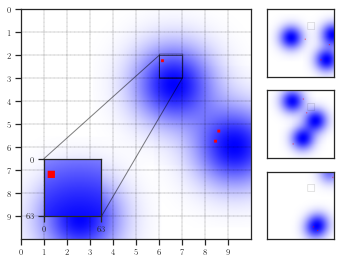

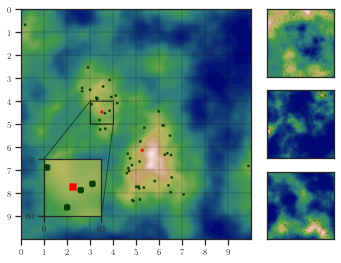

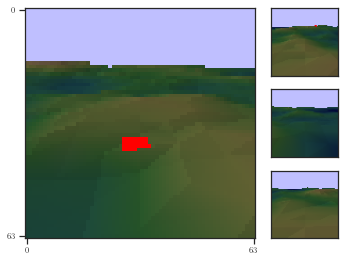

In [19]:
REPORT_LAYOUT = [
    [0, 0, 0, 1],
    [0, 0, 0, 2],
    [0, 0, 0, 3],
]

plot_environment("Gaussian-v0", seed=1, layout=REPORT_LAYOUT, position=np.array([2, 6])).savefig(figpath("gaussian", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=6, layout=REPORT_LAYOUT, position=np.array([4, 3])).savefig(figpath("terrain", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=REPORT_LAYOUT, position=np.array([2, 0])).savefig(figpath("camera", format="pgf"), dpi=300, bbox_inches='tight')

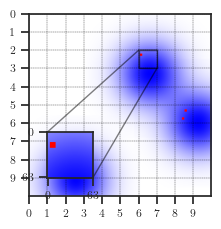

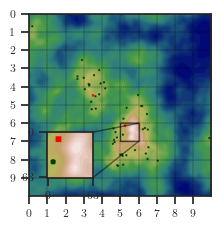

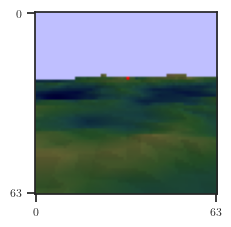

In [31]:
SLIDES_LAYOUT = [[0]]
SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH

plot_environment("Gaussian-v0", seed=1, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([2, 6])).savefig(figpath("gaussian", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=6, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([6, 5])).savefig(figpath("terrain", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([10, 5])).savefig(figpath("camera", format="pdf"), dpi=300, bbox_inches='tight')

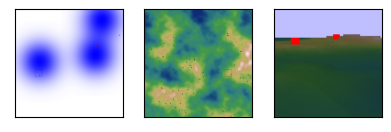

In [13]:
import gym
import gym_search

SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH
LAYOUT = [[0, 1, 2]]
ENV_IDS = ["Gaussian-v0", "Terrain-v0", "Camera-v0"]
SEEDS = [0, 0, 0]
POSITIONS = [np.array([9, 3]), np.array([9, 12]), np.array([9, 3])]
RATIO = 1.0/len(LAYOUT)

fig, axs = plt.subplot_mosaic(LAYOUT, figsize=figsize(ratio=RATIO, width=SLIDES_TEXTWIDTH_IN))
envs = [gym.make(env_id) for env_id in ENV_IDS]

for i in range(len(ENV_IDS)):
    ax, env, seed, position = axs[i], envs[i], SEEDS[i], POSITIONS[i]
    env.reset(seed=seed)
    env.plot(ax, overlay=False, position=position)

fig.savefig(figpath("environments", format="pdf"), dpi=300, bbox_inches='tight')

### Paths

In [49]:
import gym
import gym_search
import rl
import torch as th
import numpy as np

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from test import play

        
def plot_path(env_id, agent=None, model=None, device=None, seed=None, xlabel="$p_1$", ylabel="$p_0$"):
    assert agent is not None or model is not None
    assert model is None or device is not None

    fig, ax = plt.subplots(figsize=figsize(width=TEXTWIDTH_IN*0.75, ratio=0.9))
    env = gym.make(env_id)

    info, = play(1, env, agent=agent, model=model, device=device, hidden=True, seed=seed)
    path = np.array(info["path"])    

    green = sns.color_palette()[0]
    red = sns.color_palette()[1]
    blue = sns.color_palette()[2]

    cmap = sns.dark_palette(blue, reverse=True, as_cmap=True)
    c = cmap(np.linspace(0.0, 1.0, len(path)))

    for i, (p1, p2) in enumerate(zip(path, path[1:])):
        x = [p1[1], p2[1]]
        y = [p1[0], p2[0]]
        ax.plot(x, y, color=c[i], linewidth=2, alpha=1)

    targets = np.array(info["targets"])
    ax.scatter(targets[:,1],targets[:,0], color=red, marker="o", label="target", zorder=100)

    triggers = np.array([p for p, a in zip(info["path"], info["actions"]) if a == 0])
    ax.scatter(triggers[:,1], triggers[:,0], color=green, marker="x", label="indicate", zorder=100)
    
    ax.set_ylim(-1, env.shape[0])
    ax.set_ylim(-1, env.shape[1])
    ax.set_yticks(range(env.shape[0]))
    ax.set_xticks(range(env.shape[1]))
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.invert_yaxis()

    ax.grid(color="black", linestyle='--', linewidth=0.25)
    ax.legend(frameon=False)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(path)))
    fig.colorbar(sm, label="time step")

    fig.tight_layout()

    return fig

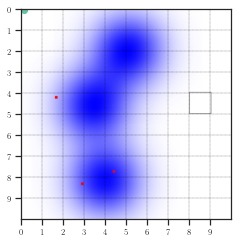

In [64]:
SEED = 0
ENV_ID = "Gaussian-v0"
AGENTS = ["random", "greedy", "exhaustive"]
MODELS = [("lstm", "models/gaussian/lstm/0.pt"), ("map", "models/gaussian/map/0.pt")]

env = gym.make(ENV_ID)
env.reset(seed=SEED)
img = env.render()

fig, ax = plt.subplots(figsize=figsize())
ax.grid(color="black", linestyle='--', linewidth=0.25)
ax.set_yticks(range(0, img.shape[0], env.view[0]))
ax.set_xticks(range(0, img.shape[1], env.view[1]))
ax.set_yticklabels(range(env.shape[0]))
ax.set_xticklabels(range(env.shape[1]))
ax.imshow(img)

fig.tight_layout()
fig.savefig(figpath(f"path-scene", format="pgf"), dpi=300)

In [65]:
env.position

array([4, 8])

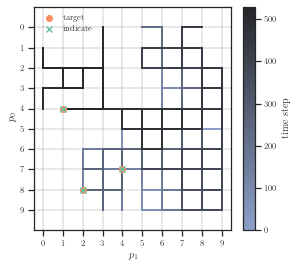

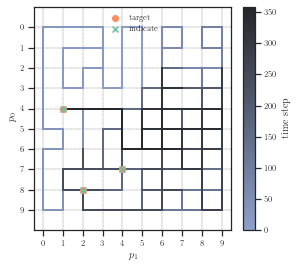

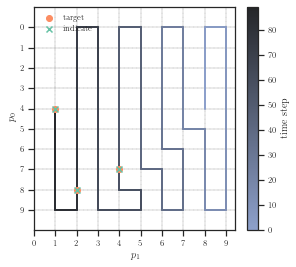

In [60]:
for agent in AGENTS:
    fig = plot_path(ENV_ID, agent=agent, seed=SEED)
    fig.savefig(figpath(f"path-{agent}", format="pgf"), dpi=300)

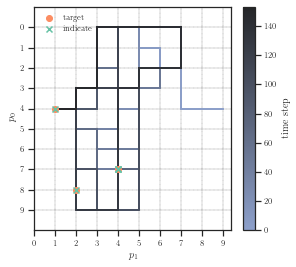

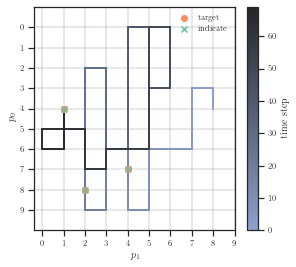

In [63]:
device = th.device("cuda")
for name, file in MODELS:
    model = th.load(file)
    plot_path(ENV_ID, model=model, device=device, seed=SEED).savefig(figpath(f"path-{name}", format="pgf"), dpi=300)

## Experiments

In [8]:
import csv

# https://github.com/openai/train-procgen/blob/master/train_procgen

def ema(data_in, smoothing=0):
    data_out = np.zeros_like(data_in)
    curr = np.nan

    for i in range(len(data_in)):
        x = data_in[i]
        if np.isnan(curr):
            curr = x
        else:
            curr = (1 - smoothing) * x + smoothing * curr

        data_out[i] = curr

    return data_out


def plot_data_mean_std(ax, data_y, data_x=None, x_scale=1, smoothing=0, first_valid=0, label=None):
    data_y = data_y[:,first_valid:]
    nx, num_datapoint = np.shape(data_y)

    if smoothing > 0:
        for i in range(nx):
            data_y[i,...] = ema(data_y[i,...], smoothing)

    if data_x is None:
        data_x = (np.array(range(num_datapoint)) + first_valid) * x_scale

    data_mean = np.mean(data_y, axis=0)
    data_std = np.std(data_y, axis=0, ddof=1)

    line, = ax.plot(data_x, data_mean, label=label, linestyle='solid', alpha=1, rasterized=True)
    ax.fill_between(data_x, data_mean - data_std, data_mean + data_std, color=line.get_color(), alpha=.25, linewidth=0.0, rasterized=True)


def read_csv(filename, key_name):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        key_index = -1

        values = []

        for line_num, row in enumerate(csv_reader):
            row = [x.lower() for x in row]

            if line_num == 0:
                idxs = [i for i, val in enumerate(row) if val == key_name]
                key_index = idxs[0]
            else:
                values.append(row[key_index])

    return np.array(values, dtype=np.float32)

def plot_values(ax, all_values, max_x=0, label=None, **kwargs):
    if max_x > 0:
        all_values = all_values[...,:max_x]

    if ax is not None:
        plot_data_mean_std(ax, all_values, label=label, **kwargs)

    return all_values

### Curves

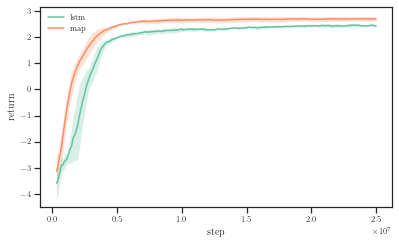

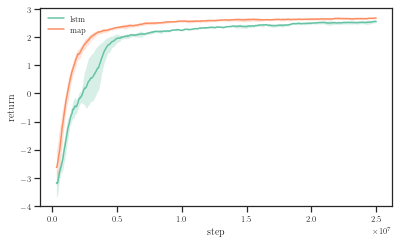

In [13]:
timesteps = int(25e6)
environments = ["gaussian", "terrain"]#, "camera"]
seeds = [0, 1, 2]
field = "return"

for environment in environments:
    fig, ax = plt.subplots(figsize=figsize(width=TEXTWIDTH_IN))

    data = {
        "lstm": [f"results/{environment}/lstm/{seed}/train.csv" for seed in seeds],
        "map": [f"results/{environment}/map/{seed}/train.csv" for seed in seeds],
    }

    for label, csv_files in data.items():
        raw_data = np.array([read_csv(f, field) for f in csv_files])
        plot_values(ax, raw_data, label=label, smoothing=0.95, first_valid=20, x_scale=timesteps/raw_data.shape[1])

    ax.set_xlabel("step")
    ax.set_ylabel(field)
    ax.legend(frameon=False)

    #fig.suptitle(fr"${shape} \times {shape}$ search space")
    fig.tight_layout()
    #fig.savefig(figpath(f"shape-{shape}"))

### Quality

In [2]:
import pandas as pd
import numpy as np

ENVIRONMENTS = ["gaussian", "terrain", "camera"]
AGENTS = ["random", "greedy", "exhaustive", "human", "lstm", "map"]
METRICS = ["spl", "success", "length"]

for env in ENVIRONMENTS:

    print(env)

    for agent in AGENTS:

        df = pd.read_csv(f"results/{env}/{agent}/test.csv", index_col="id")
        metrics = []

        for key in METRICS:
            metrics.append((np.mean(df[key]), np.std(df[key], ddof=1)))
    
        print(f"{agent} & " + " & ".join(fr"${mean:.2f} \pm {std:.2f}$" for mean, std in metrics) + r"\\")

gaussian
random & $0.06 \pm 0.01$ & $0.92 \pm 0.06$ & $369.07 \pm 24.93$\\
greedy & $0.17 \pm 0.00$ & $1.00 \pm 0.00$ & $147.12 \pm 2.38$\\
exhaustive & $0.21 \pm 0.00$ & $1.00 \pm 0.00$ & $83.37 \pm 2.88$\\
human & $0.23 \pm 0.03$ & $1.00 \pm 0.00$ & $80.97 \pm 13.49$\\
lstm & $0.24 \pm 0.03$ & $0.99 \pm 0.01$ & $101.25 \pm 13.32$\\
map & $0.29 \pm 0.02$ & $0.99 \pm 0.01$ & $72.16 \pm 5.97$\\
terrain
random & $0.06 \pm 0.01$ & $0.89 \pm 0.04$ & $366.05 \pm 26.96$\\
greedy & $0.17 \pm 0.01$ & $1.00 \pm 0.00$ & $141.01 \pm 2.31$\\
exhaustive & $0.22 \pm 0.00$ & $1.00 \pm 0.00$ & $84.11 \pm 0.84$\\
human & $0.26 \pm 0.02$ & $1.00 \pm 0.00$ & $76.73 \pm 5.33$\\
lstm & $0.25 \pm 0.02$ & $1.00 \pm 0.01$ & $103.76 \pm 11.69$\\
map & $0.27 \pm 0.01$ & $1.00 \pm 0.00$ & $79.60 \pm 6.88$\\
camera
random & $0.04 \pm 0.00$ & $0.62 \pm 0.03$ & $545.09 \pm 56.25$\\
greedy & $0.12 \pm 0.01$ & $0.97 \pm 0.01$ & $255.60 \pm 10.44$\\
exhaustive & $0.37 \pm 0.00$ & $1.00 \pm 0.00$ & $67.03 \pm 0.00$\\
h

### Shape

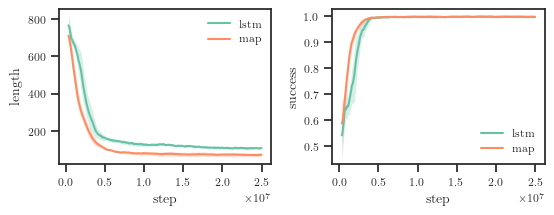

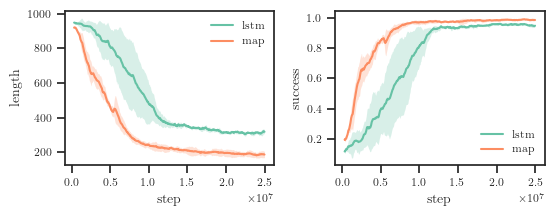

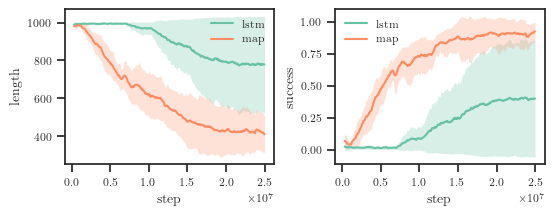

In [86]:
timesteps = int(25e6)
shapes = [10, 15, 20]
fields = ["length", "success"]
seeds = [0, 1, 2, 3]

for shape in shapes:
    fig, axs = plt.subplots(1, 2, figsize=figsize(width=TEXTWIDTH_IN, ratio=0.4))

    data = {
        "lstm": [f"results/shape/lstm/{shape}/{seed}/train.csv" for seed in seeds],
        "map": [f"results/shape/map/{shape}/{seed}/train.csv" for seed in seeds],
    }

    for ax, field in zip(axs, fields):
        for label, csv_files in data.items():
            raw_data = np.array([read_csv(f, field) for f in csv_files])
            plot_values(ax, raw_data, label=label, smoothing=0.95, first_valid=20, x_scale=timesteps/raw_data.shape[1])

        ax.set_xlabel("step")
        ax.set_ylabel(field)
        ax.legend(frameon=False)

    #fig.suptitle(fr"${shape} \times {shape}$ search space")
    fig.tight_layout()
    fig.savefig(figpath(f"shape-{shape}"))

### Samples

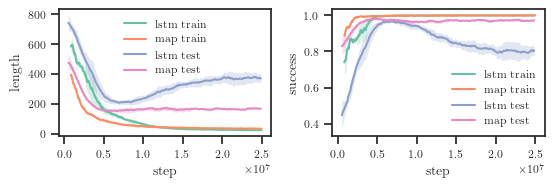

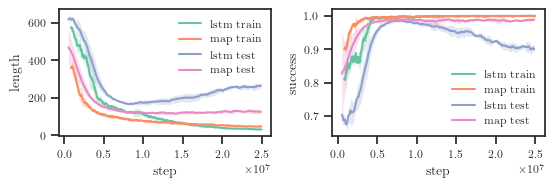

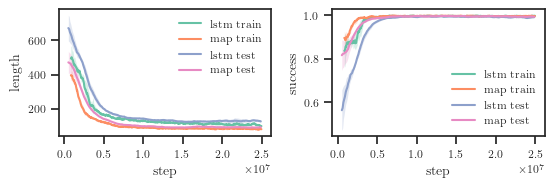

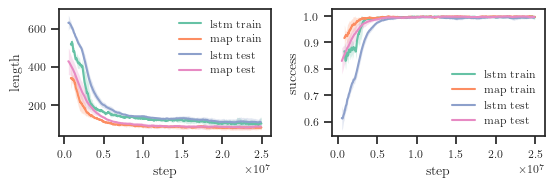

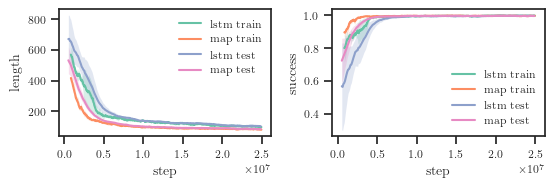

In [88]:
timesteps = int(25e6)
fields = ["length", "success"]
seeds = range(3)
samples = [500, 1000, 5000, 10000, "null"]

for sample in samples:
    fig, axs = plt.subplots(1, 2, figsize=figsize(width=TEXTWIDTH_IN, ratio=0.35))

    train_data = {
        "lstm train": [f"results/sample/lstm/{sample}/{seed}/train.csv" for seed in seeds],
        "map train": [f"results/sample/map/{sample}/{seed}/train.csv" for seed in seeds],
    }

    test_data = {
        "lstm test": [f"results/sample/lstm/{sample}/{seed}/test.csv" for seed in seeds],
        "map test": [f"results/sample/map/{sample}/{seed}/test.csv" for seed in seeds],
    }

    for ax, field in zip(axs, fields):

        for label, csv_files in train_data.items():
            raw_data = np.array([read_csv(f, field) for f in csv_files])
            plot_values(ax, raw_data, label=label, smoothing=0.9, first_valid=50, x_scale=timesteps/raw_data.shape[1])

        for label, csv_files in test_data.items():
            raw_data = np.array([read_csv(f, field) for f in csv_files])
            plot_values(ax, raw_data, label=label, smoothing=0.9, first_valid=5, x_scale=timesteps/raw_data.shape[1])

        ax.set_xlabel("step")
        ax.set_ylabel(field)
        ax.legend(frameon=False)

    #fig.suptitle(f"{sample} training samples", fontsize=10)
    fig.tight_layout()
    fig.savefig(figpath(f"sample-{sample}"))

## Extra

### Tensorboard

In [108]:
from glob import glob
from scipy import stats
from functools import lru_cache
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator, STORE_EVERYTHING_SIZE_GUIDANCE


def load_scalars(events, tag):
    event_acc = EventAccumulator(events, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
    event_acc.Reload()
    scalars = event_acc.Scalars(tag)
    df = pd.DataFrame(scalars)
    return df


def smooth(scalars, weight):
    last = scalars[0]
    smoothed = []

    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

### Latent Images

In [1]:
import torch as th
import numpy as np
from sklearn.decomposition import PCA

import rl
import gym
import gym_search

def image_decomposition(x):
    h, w, c = x.shape
    if c == 3: return x
    x = x.flatten().reshape(h*w, c)
    pca = PCA(n_components=3).fit(x)
    y = pca.transform(x)
    img = y.reshape(h, w, 3)
    img *= (255.0/img.max())
    return np.abs(img)

#device = th.device("cpu")
#envs = gym.vector.make("Terrain-v0", num_envs=1)
#agent = th.load("models/baseline-small.pt").to(device)
#obs = envs.reset()